# Interactive Demo

This is an interactive version of the demo. It runs over the same mock data using the same procedure as the implementation in the default *prospector.py* Python script. 

First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which utilizes some routines for computing spectrophotometry, and
- **prospect**, which is where most of the actual heavy lifting is done.

Let's import those now.

In [2]:
import fsps
import sedpy
import prospect

/home/joshspeagle/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Setup

We now want to initialize our model.

In [3]:
from prospect.models import model_setup

Let's now load in our model parameter file.

In [4]:
clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print run_params

{'tau': 3.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'whi': 7200.0, 'initial_disp': 0.1, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'maxfev': 5000, 'do_powell': True, 'nwalkers': 128, 'mass': 10000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 12.0, 'zcontinuous': 1, 'wlo': 3750.0, 'debug': False, 'snr': 20.0, 'add_noise': False, 'logify_spectrum': False}


Our model is composed of four components:
- an **stellar population synthesis (SPS)** model for the underlying physical parameters,
- a **noise model** for the underlying calibration vector,
- an underlying **statistical model** composed of a set of parameters, priors, etc., and
- a set of **observations** we are trying to fit.

See the *demo_mock_params.py* file for additional info on the specific parameters we are initializing here.

In [5]:
# load sps model (default)
sps = model_setup.load_sps(**run_params)

In [6]:
# load noise model (none)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

In [7]:
# demo model
model = model_setup.load_model(**run_params)

In [8]:
# demo data (generated from the script)
obs = model_setup.load_obs(**run_params)

reading py script demo_mock_params.py


Now that we've initialized the components of our model, we need to define how we want to compare our model to the data by establishing the appropriate **likelihood**. In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from Prospector.

In [9]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

In [10]:
def lnprobfn(theta):
    """Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    
    else:
        return -np.infty

## Running Prospector

### Outputs

Before we start running anything, let's just check whether we can write out our fits to an HDF5 file. If not, we'll just dump them at the end.

In [11]:
from prospect.io import write_results

In [12]:
outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

Writing to file output/demo_mock_1489033221_mcmc.h5
Could not JSON serialize mock_params, pickled instead


### Model Preview

Let's also take a quick look at our model/data to get a sense of what we're dealing with and what we're fitting for.

In [13]:
print 'Free params:', model.free_params
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Fixed params: ['zred', 'sfh', 'pmetals', 'sfstart', 'tburst', 'fburst', 'dust1', 'dust_index', 'dust1_index', 'dust_tesc', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'gas_logz', 'gas_logu', 'phot_jitter']


So we're fitting for 5 parameters here:
- stellar mass $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), 
- age $t$ of the galaxy, and 
- dust attenuation of old stellar populations $A_V$.

Everything else here is fixed either explicitly in the *demo_mock_params.py* file or implicitly in the FSPS defaults.

### SED Preview

Let's now see what our model and data look like.

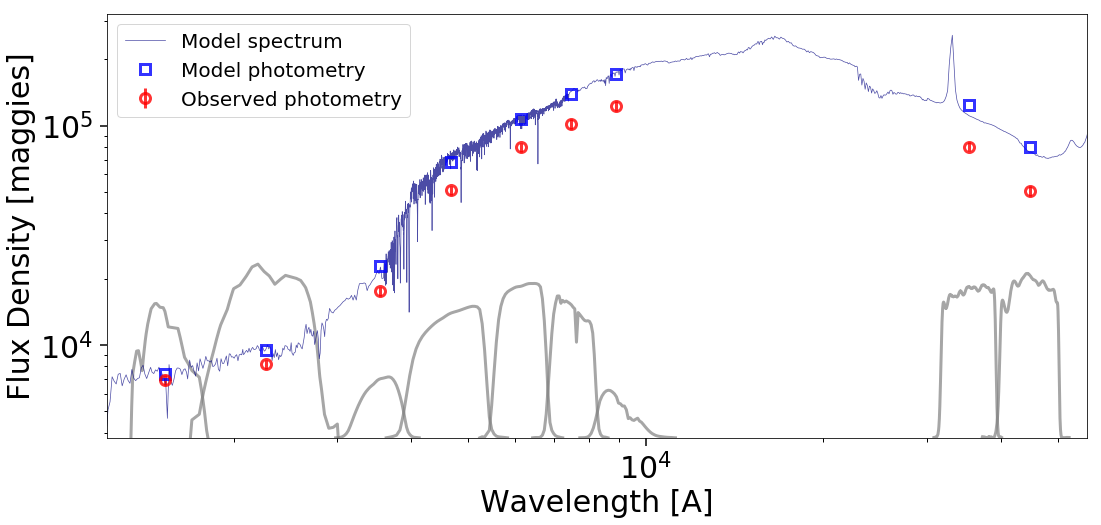

In [14]:
wspec = sps.csp.wavelengths # spectral wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mextra_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Minimization Step

We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.

In [15]:
from prospect import fitting
from scipy.optimize import minimize

In [16]:
def chisqfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

verbose=False # don't output function calls

# start minimization
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(chisqfn, initial_theta, method=min_method)
pdur = time.time() - ts

# reinitialize fit
initial_center = fitting.reinitialize(min_results.x, model, edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = -1 * min_results['fun']

# output results
print('done {0} in {1}s'.format(min_method,pdur))
print('best {0} guess: {1}'.format(min_method,initial_center))
print('best {0} lnp: {1}'.format(min_method,initial_prob))

done Nelder-Mead in 11.3595998287s
best Nelder-Mead guess: [  6.86764889e+06  -3.48193074e-01   1.21695018e+00   5.81992190e+00
   2.26568029e-01]
best Nelder-Mead lnp: -76.7736484097


Note that creating a new model with FSPS is somewhat time-intensive, but once the relevant model(s) have been loaded they are subsequently stored in cache so similar models can be generated much more quickly.

Now let's see how our model looks.

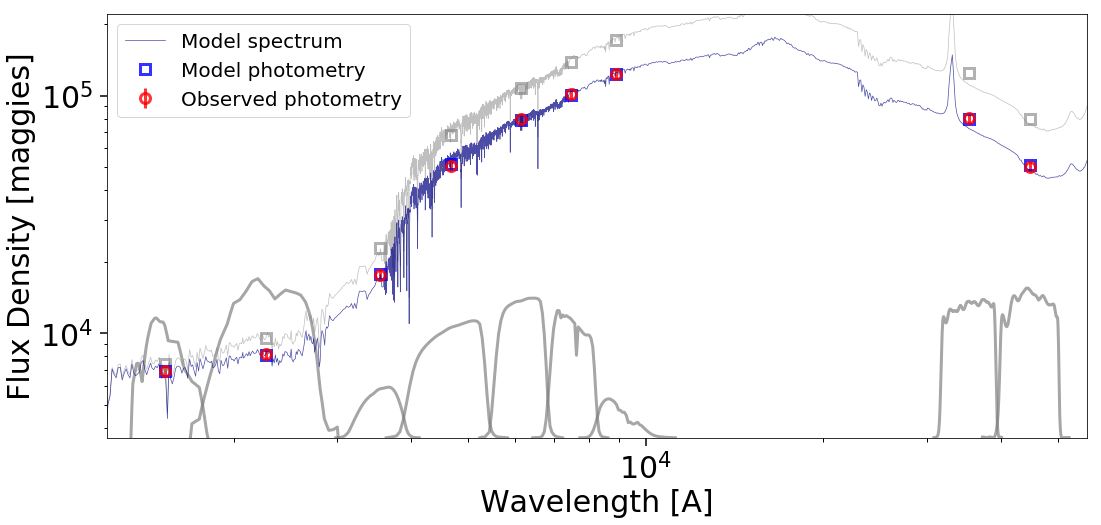

In [17]:
theta = model.rectify_theta(min_results.x) # initial parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Sampling the Posterior

Now that we're somewhat burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC). Prospector by default uses **emcee**, and will try to parallelize the process over multiple cores when available. Let's check how many cores we have available.

In [18]:
try:
    from emcee.utils import MPIPool
    pool = MPIPool(debug=False, loadbalance=True)
    if not pool.is_master():
        # Wait for instructions from the master process.
        pool.wait()
        sys.exit(0)
except(ImportError, ValueError):
    pool = None
    print('Not using MPI')

Not using MPI


In [19]:
def halt(message):
    """Exit, closing pool safely.
    """
    print(message)
    try:
        pool.close()
    except:
        pass

With that all done, let's go ahead and start sampling!

In [20]:
postkwargs = {}

fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                postkwargs=postkwargs, initial_prob=initial_prob,
                                pool=pool, hdf5=hfile, **run_params)
esampler, burn_p0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

/home/joshspeagle/anaconda/lib/python2.7/site-packages/prospect-391bb99-py2.7.egg/prospect/models/priors.py:65: RuntimeWarning: invalid value encountered in log


done emcee in 617.049119949s


Now that everything's all set, let's save our results to disk.

In [21]:
write_results.write_pickles(run_params, model, obs, esampler, min_results,
                            outroot=outroot, toptimize=pdur, tsample=edur,
                            sampling_initial_center=initial_center,
                            post_burnin_center=burn_p0,
                            post_burnin_prob=burn_prob0)

if hfile is None:
    hfile = hfilename
write_results.write_hdf5(hfile, run_params, model, obs, esampler, min_results,
                         toptimize=pdur, tsample=edur,
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_p0,
                         post_burnin_prob=burn_prob0)

halt('Finished')

Finished


## Visualizing the Results

There are a few basic plotting tools available to do a quick check on the results available in *prospect.io.read_results* and *prospect.utils.plotting*. We'll hack a few of these together in *plot_utils* here in the demo folder to make them a bit more amenable to plotting in this notebook.

In [22]:
import plot_utils as pread
from prospect.io import read_results

Reading our results from our Pickle or HDF5 file is straightforward.

In [24]:
# grab results, powell results, and our corresponding models
res, pr, mod = read_results.results_from("output/demo_mock_1489033221_mcmc.h5")

To see how our MCMC samples look, we can examine a few traces.

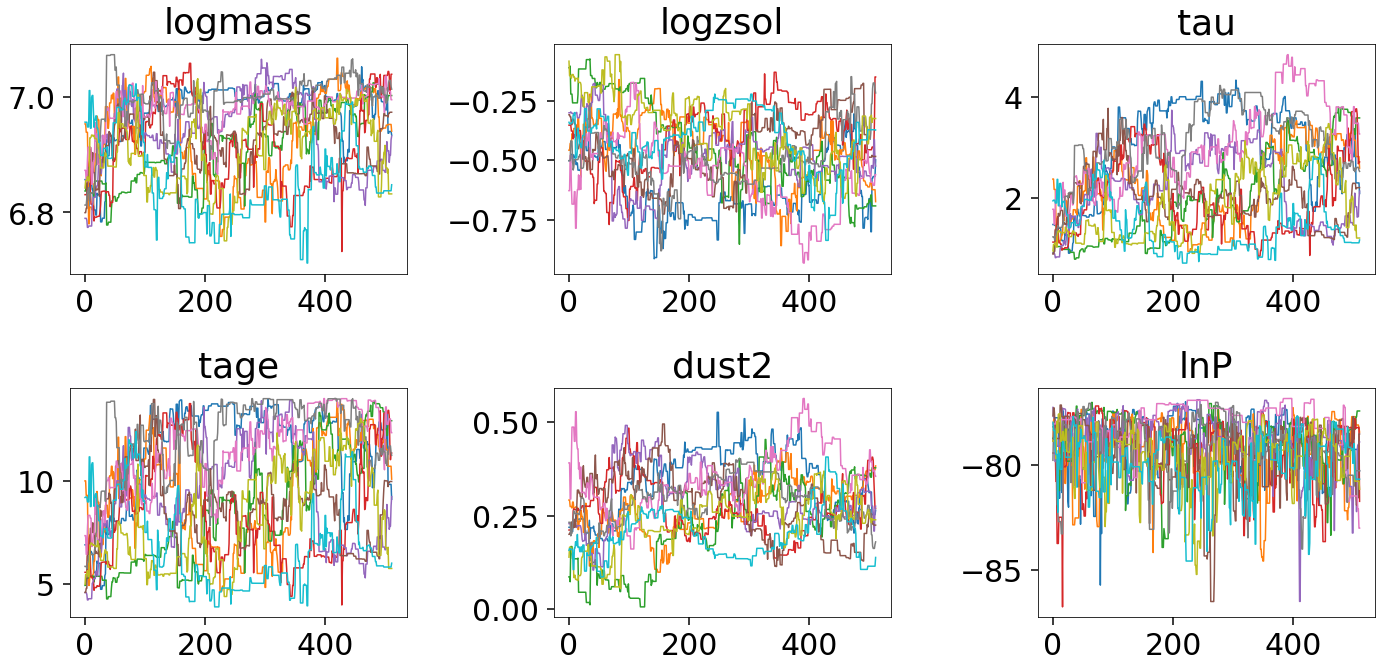

In [25]:
tracefig = pread.param_evol(res, figsize=(20,10), chains=choice(128, size=10, replace=False))

Our samples more generally can be shown using a corner/triangle plot.

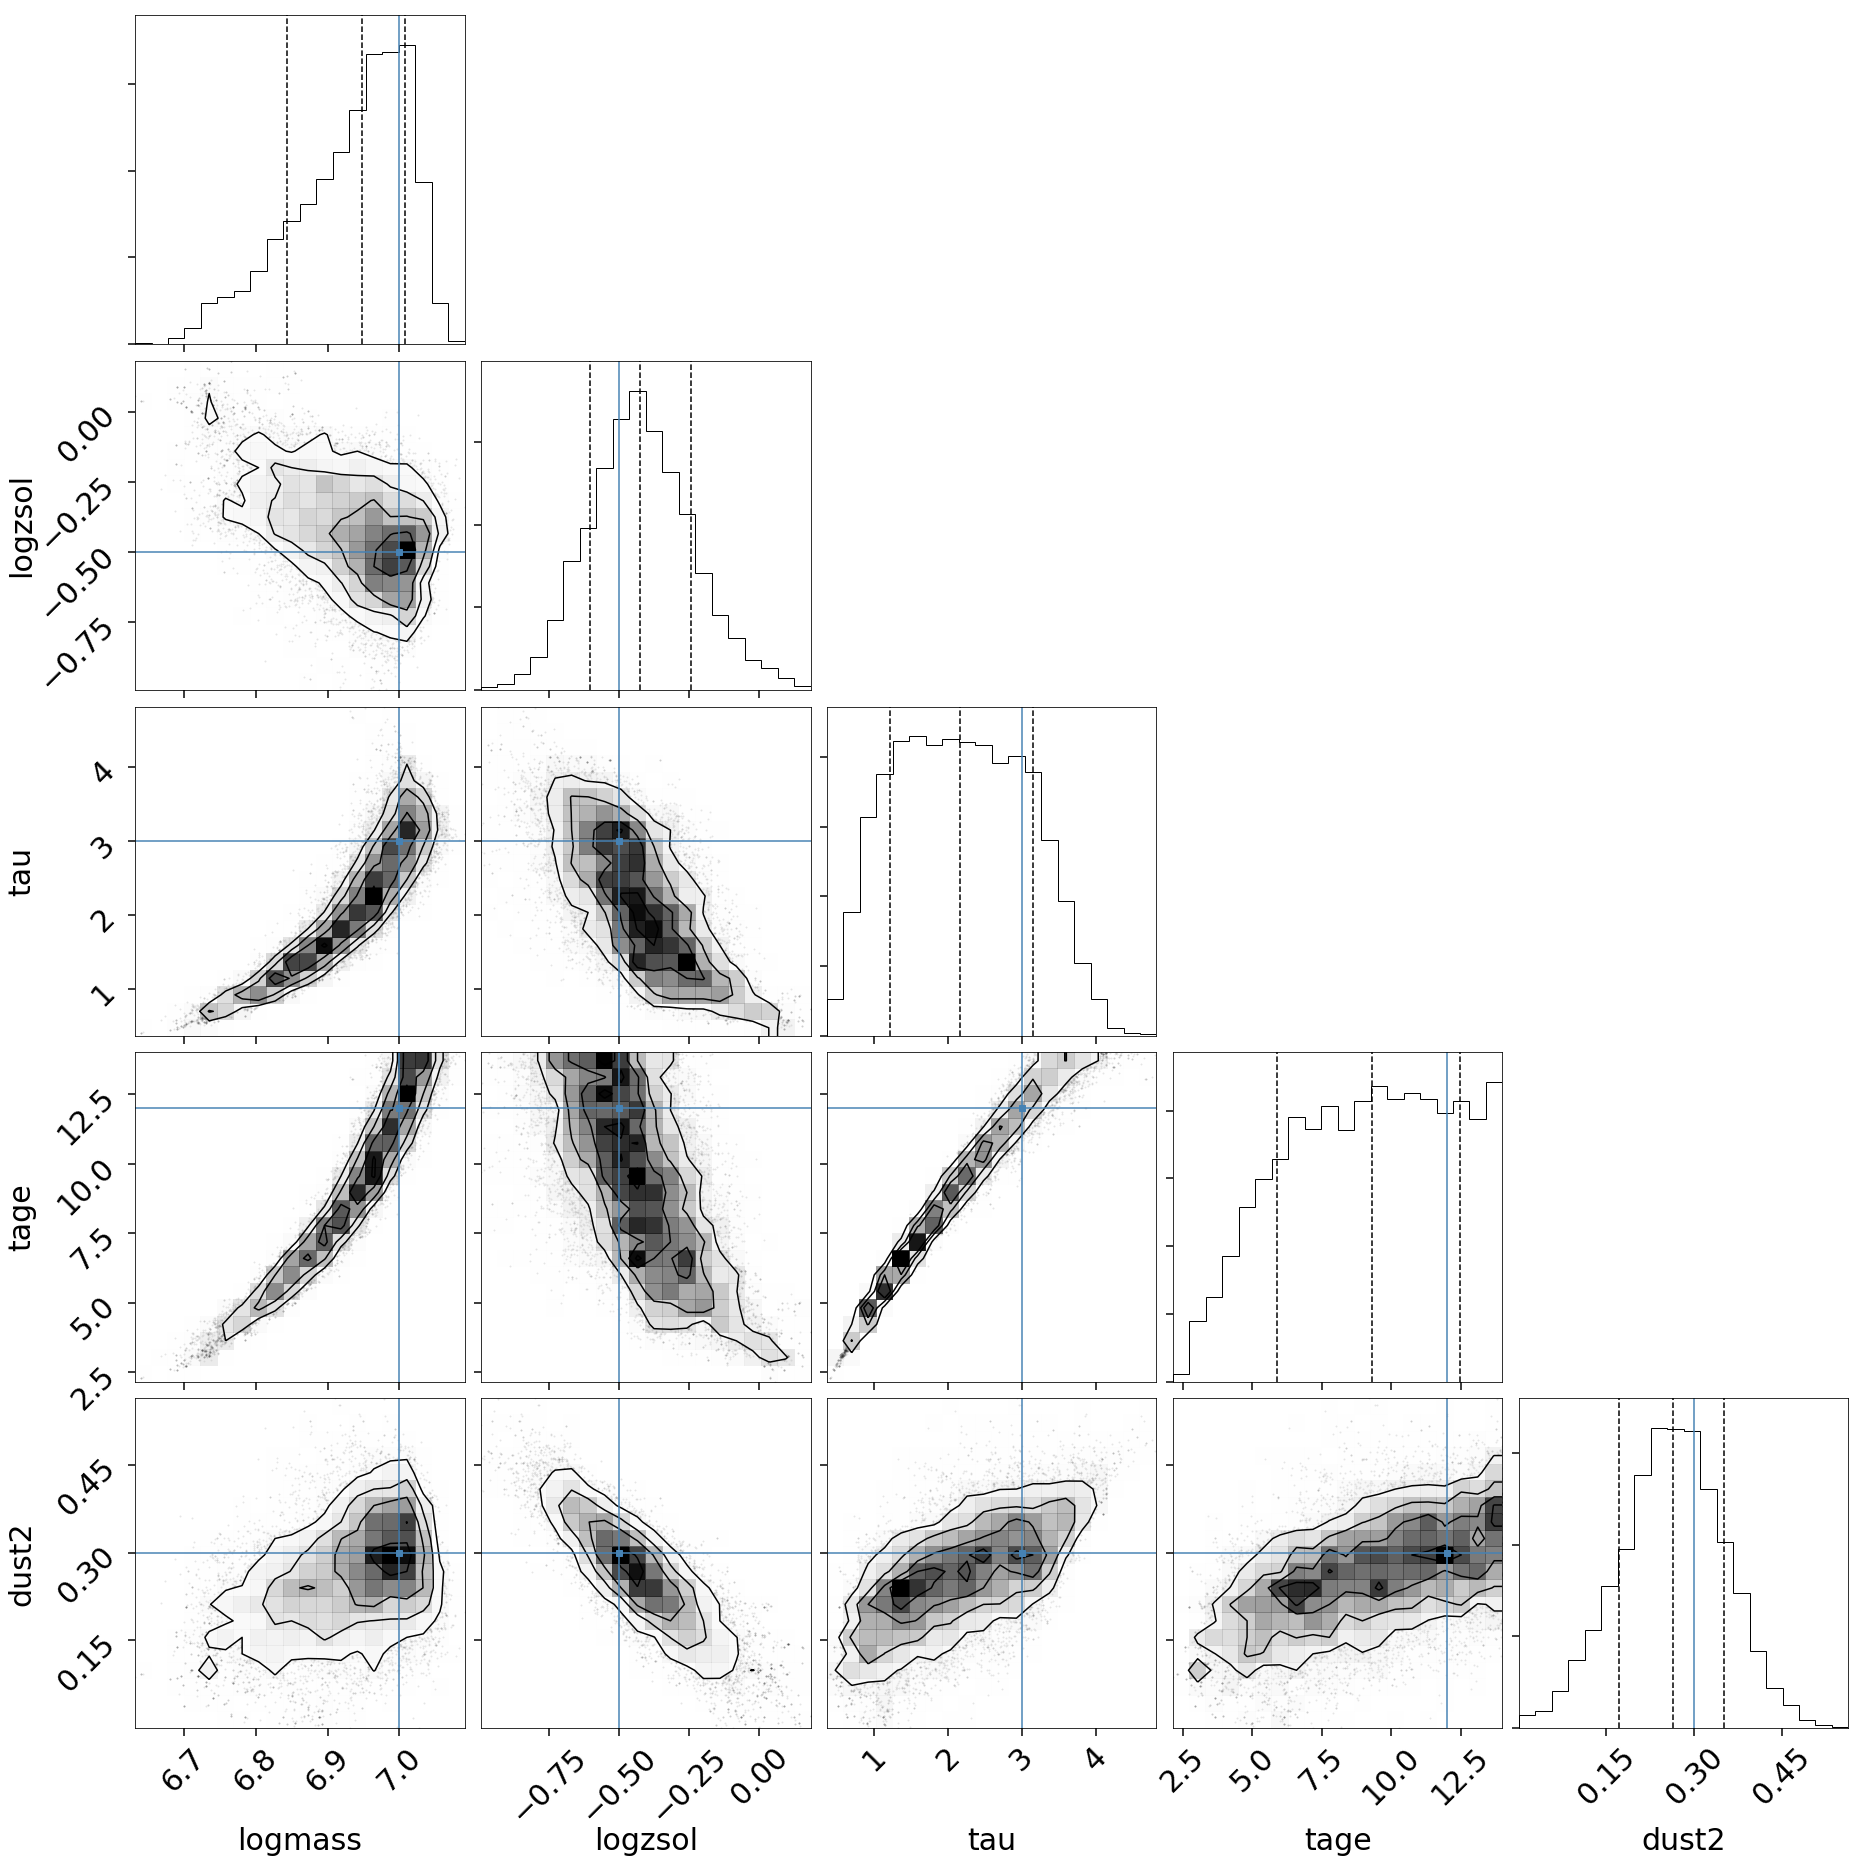

In [26]:
theta_truth = array([run_params[i] for i in ['mass','logzsol','tau','tage','dust2']])
theta_truth[0] = log10(theta_truth[0])
cornerfig = pread.subtriangle(res, start=0, thin=5, truths=theta_truth, 
                              fig=subplots(5,5,figsize=(27,27))[0])

Finally, let's just take a look at a random model drawn from our chain.

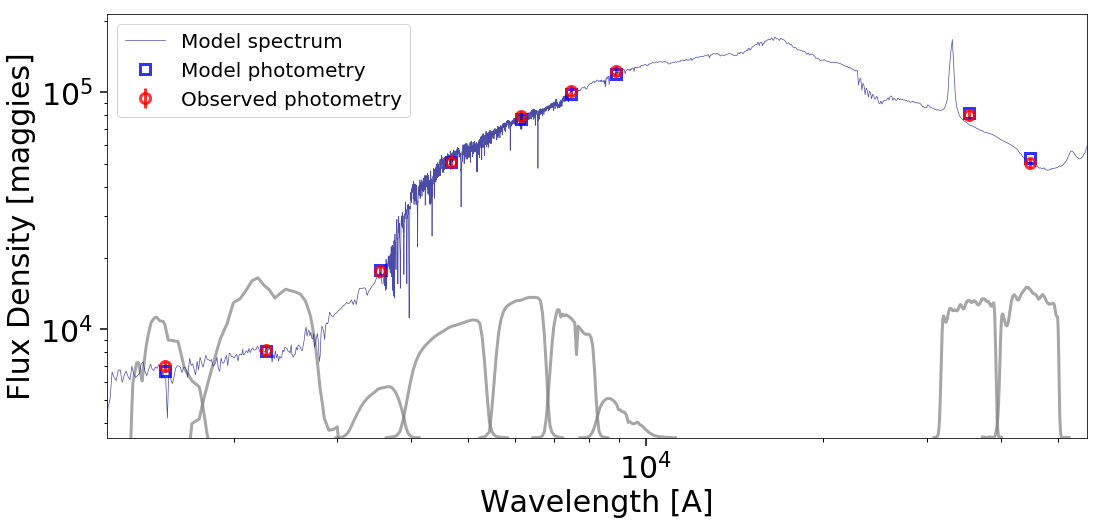

In [27]:
theta = res['chain'][randint(128), randint(512)] # initial parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()